In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

## 6.832: Problem Set #3

Due on Friday, March 15, 2019 at 17:00.  See course website for submission details. Use Drake release tag `drake-20190305`, i.e. use this notebook via `./docker_run_notebook.sh drake-20190305.`, or whichever script you need for your platform.

To submit for autograding, upload this file, *and also the inertial_wheel_pendulum.py and inertial_wheel_pendulum_visualizer.py files supplied to you with any modifications you have made*, to the "Problem Set 3, Code Submission" assignment.

---

## About this problem set

This problem set will entirely live inside this jupyter notebook.

Grades will be assigned based on three components:

- __Manually graded free-response questions__ -- the TAs will manually assign grades to your answers to short answer responses. You can write inline responses using [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) with inline LaTeX -- double-click on any problem writeup to see some examples. Double-click response areas to edit them, and press Control-Enter to finish editing them.
- __Automated code testing__ -- we will run automated tests against specific functions (see more details when we introduce the first coding test).
- __Quick code review__ -- we will perform a quick manual check to make sure you have actually implemented the functions correctly (as opposed to hacked the unit tests to pass!).

---


# 1. Lyapunov Theory

The following are a series of short answer problems meant to test your understanding of Lyapunov functions and Lyapunov theory.   

---

### Quick check for understanding

#### We recommend you stop for a second to make sure you can answer the following questions:
<font color=blue>
1. What is a Lyapunov function?

A generalization of system energy that is positive for all states (except 0 for 0 state) and decreasing over time.

2. How does Lyanpunov theory relate to robots?

Finding a Lyapunov function allows one to find a stabilizing region of an open or closed loop system. The stability of this region of attraction can then be determine to be ISL, asymptotic, or exponential based on $\dot{V}(x)$. Though finding a Lyapunov function analytically only works for very simple systems, SDP/SOS optimization methods can numerically find Lyapunov function making it more useful for general robotics. It also lends itself well to robustness analysis since finding a common Lyapunov function for a system with uncertain variables proves stability for all possible systems.

3. What is the relationship between Lyapunov functions -- we have been writing them as $V(x)$ -- and cost-to-go functions  -- we have been writing them as $J(x)$?

$J(x)$ is a lyapunov function that decreases over time at a specific rate at which cost is accumulating $\dot{J}(x)=-g(x)$ whereas a lyapunov function can decrease at any rate (which is why it's not optimal)

4. What are the conditions for making a Lyapunov function valid?


5. Just a function $V(x)$ doesn't itself demand anything about how the function will evolve over time.  How do we bring the idea of evolution over time into our Lyapunov analysis?

$\dot{V}(x)=\frac{dV}{dx}f(x)\leq 0$

6. If somebody gives you a Lyapunov function $V(x)$ and a dynamical system $\dot{x} = f(x)$, is it hard to check if $V$ is a valid Lyapunov function?

It could be since not all positive function $V(x)$ can be written as sums of squares. So it could be difficult to show $V(x)\gt 0$. Though for many cases it's easy.

7. If you would like to find a Lyapunov function on your own, how might you do that?

For systems that have energy, could start with that. Otherwise could try numerical optimization methods.

8. Can you prove the nonexistence of a Lyapunov function, for a particular system?


</font>
(We won't grade answers to these questions, but are happy to talk about your answers.  Office hours are the best opportunities to discuss.)

---

## 1.1 (2 points)

A dynamical system is defined by the equations $\dot{x_1}=f_1(x_1,x_2)$ and $\dot{x_2}=f_2(x_1,x_2)$.  You find that the function $V=\frac{1}{2}x_1^2$ has a derivative $\dot{V} = \left[\dfrac{dV}{dx_1}, \dfrac{dV}{dx_2}\right] \left[ f_1, f_2 \right]^T$ which is negative semidefinite.  What, if anything, can you prove about the behavior of this system with this function $V$?

**Short answer explanation for 1.1.**

<font color=blue>This system is stable in the sense of Lyapunov (because negative semidefinite). If it were negative definite it would have been asymptotically stable. LaSalle's invariant principle also says system state $x$ will converge to the largest invariant set where energy is no longer changing $\dot{V}=0$. Invariant set being set of states that once you start there, you never leave. So this would be satisfied by any fixed points or for example with undamped pendulum, isocontour equal energy orbit.</font>

## 1.2 (4 points)

For the system

\begin{align}
\dot{x_1}&=-\frac{6x_1}{(1+x_1^2)^2}+2x_2  \\
\dot{x_2}&=-\frac{2(x_1+x_2)}{(1+x_1^2)^2}
\end{align}

you are given the positive definite function $V(x) =\frac{x_1^2}{1 + x_1^2}+ x_2^2$ and told that, for this system, $\dot{V}$ is negative definite over the entire space.  Is $V$ a valid Lyapunov function which proves global asymptotic stability to the origin for the system described by these equations?  Why or why not?  Hint: Trying simulating a few trajectories of this system or plotting the vector field to build more intuition before answering this problem.

In [8]:
# Sandbox for doing math, plotting
def dynamics1p2(z):
    x1 = z[0]
    x2 = z[1]
    x1dot = -(6*x1)/(1+x1**2)**2+2*x2
    x2dot = -2*(x1+x2)/(1+x1**2)**2
    return [x1dot, x2dot]

<IPython.core.display.Javascript object>


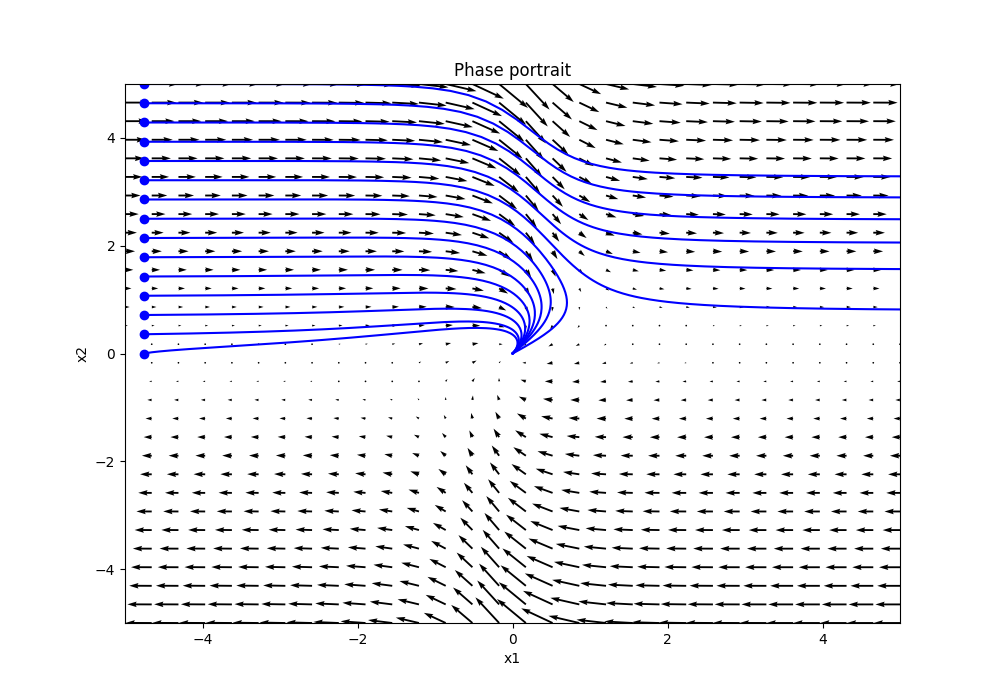

In [9]:
# phase portrait
x_range = 5
y_range = 5
bins = 30
x1 = np.linspace(-x_range,x_range,bins)
x2 = np.linspace(-y_range,y_range,bins)
X1, X2 = np.meshgrid(x1,x2)
fig, ax = plt.subplots(figsize = (10,7))
X1dot, X2dot = dynamics1p2([X1,X2])
ax.quiver(X1,X2,X1dot,X2dot)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Phase portrait")

# sample trajectories
tspan = np.linspace(0,20,1000)
z_init_list = []
for i in np.linspace(0,y_range,15):
    z_init_list.append([-0.95*x_range,i])
    
for z_init in z_init_list:
    zarray = integrate.odeint(lambda z,t : dynamics1p2(z),z_init,tspan)
    ax.plot(zarray[:,0],zarray[:,1],'b')
    ax.plot(zarray[0,0],zarray[0,1],'ob')
ax.set(xlim=[-x_range,x_range], ylim=[-y_range,y_range]);

**Short answer explanation for 1.2.**
<font color=blue>

V is not a valid Lyapunov function over the entire space since the phase portrait shows that the dynamics are not globally stable (for $x_2$ initial conditions above some threshold). This is because the Lyapunov function violates the third condition that as $||x||\rightarrow \inf$, $V(x)\rightarrow \inf$. In this system, as $x_1\rightarrow \inf$, $V(x)\rightarrow x_2$. For large $x_1$ values, the dynamics approach $\dot{x}_1 = 2x_2$, $\dot{x}_2 = 0$. So starting at large positive $x_1$ and positive $x_2$ means $x_1\rightarrow \inf$ faster than $x_2$ can pull the system back to stability.</font>

## 1.3 (2 points)

Given dynamics $\dot{x} = f(x)$ and a Lyapunov candidate $V(x)$, let $D$ be any domain such that for all $\hat{x} \in D$, $V(\hat{x})$ is positive definite and $\dot{V}(\hat{x})$ is negative definite. 

1) Can we say that all initial conditions inside $D$ will stay inside $D$? Why or why not?

2) Can we say that all initial conditions inside $D$ will converge to the origin? Why or why not?

**Short answer explanation for 1.3.**

<font color = blue>
1) No, since $D$ can be arbitrary. But we can find the smallest sub-level set of $V(x)$ that contains $D$. Then $x$ will stay inside this level set since $V(x)$ is always getting smaller.

2) Yes, since $\dot{V}$ is negative definite, this region of attraction is asymptotically stable.
</font>

## 1.4 (2 points)

If $V_1(x)$ and $V_2(x)$ are valid Lyapunov functions that prove global stability of a system to the origin, does $V_1(x)$ necessarily equal $V_2(x)$? In other words, are Lyapunov functions unique? Why or why not?

**Short answer explanation for 1.4.**

<font color=blue>Not necessarily unique. Counter example is multiplying energy by 2 gives different but equally valid Lyapunov.</font>

## 1.5 (4 points)

Consider the system given by
\begin{equation}
\dot{x}= \left(\begin{array}{c} {x_2} - {{x_1}}^3\\  - {{x_2}}^3 - {x_1} \end{array}\right)\label{p2System}
\end{equation}
Show that  the Lyapunov function 

$$
V(x) = x_1^2 + x_2^2 
$$

proves global asymptotic stability of the above equation to the origin.

**Short answer explanation for 1.5.**

<font color=blue>
$$
\dot{V}(x)=\nabla V(x)f(x) = 
\\
\begin{bmatrix}2x_1 & 2x_2\end{bmatrix}
\begin{bmatrix}x_2-x_1^3 \\ -x_2^3-x_1\end{bmatrix}=
\\ -2x_1^4-2x_2^4
$$
Since the Lyapunov fn is strictly positive, time derivative is strictly negative, and Lyapunov goes to $\inf$ as $x$ goes to $\inf$, system is globally asymptotically stable
</font>

# 2. Sums of Squares (SOS) for Lyapunov functions

---

### Quick check for understanding

#### We recommend you stop for a second to make sure you can answer the following questions:

1. What is the simplest example of a function that is a sum of squares?

$x_1^2+x_2^2$

2. What is arguably the most useful property of functions that are sums of squares? When are they positive?  When are they negative?

Sum of square functions are always positive or zero, never negative

3. Are there functions that also have this property, but do not belong to the set of sums of squares?  (Hint: Google the Motzkin polynomial mentioned in class.)

yes, but they are the exception to the rule (e.g. 6-hump cammel or something).

4. How do sums of squares (SOS) relate to Lyapunov functions?

SDP can be used to find Lyapunov functions for linear systems, assuming the form is quadratic $V(x)=x^TPx\geq0$. This can be extended to cover non-linear polynomial dynamic systems (by assuming a form $V(x)=m(x)^TPm(x)\geq0$ where $m(x)$ is usually monomials, e.g. $[x1^2, x1x2, x2^2]$ for 4th order polynomial dynamics. This results in a sum of squares constraint, which garuntees the Lyapunov fn is positive.

5. Specifically, which property (or properties) of Lyapunov functions do we relate to them being sums of squares or not?

6. To make an expressive set of functions over our state space, we choose some set of monomials $m(x)$.  What are some examples of good choices for $m(x)$?

7. What does the form $V(x) = m^T(x) Q m^T(x)$ have to do with a function being sums of squares?

8. Searching for $Q$ in the above question can be formulated as a Semidefinite Program. What is the difference between Quadratic Programming and Semidefinite Programming?

9. If we find, using SOS optimization, a valid Lyapunov function, then what does this say about our system?

10. If we cannot find, using SOS optimization, a valid Lyapunov function, then what does this say about our system?

11. We are using SOS to help find Lyapunov functions.  How does this help our robots?

(We won't grade answers to these questions, but are happy to talk about your answers.  Office hours are the best opportunities to discuss.)

---

## 2.1 (4 points, 4/4 autograded)

Consider the polynomial:
$$
p(x_1,x_2) = 2x_1^4 + 2x_1^3x_2 - x_1^2x_2^2 + 5x_2^4.
$$

**Prove that this polynomial is nonnegative** by finding a representation as follows:

$$
p(x_1,x_2) = \left[ \begin{array}{c}
x_1^2 \\
x_2^2 \\
x_1 x_2 \end{array} \right]^T
\ \ \
Q
\ \ \
\left[ \begin{array}{c}
x_1^2 \\
x_2^2 \\
x_1 x_2 \end{array} \right]
$$

where \(Q\) is given by:
$$
Q = \left[ \begin{array}{ccc}
2, \ a, \ 1 \\
a, \ 5, \ 0 \\
1, \ 0, \ b \end{array} \right].
$$

Here \(Q\) must be positive semidefinite. **Type your value for $Q$ below.** Make sure that the resulting \(Q\) is positive semidefinite.

In [10]:
'''
User code for problem 2.1.
'''
import numpy as np
def problem_2_1_get_Q():
    # Set a and b appropriately...
    a = -1
    b = 1
    Q = np.array([
        [2, a, 1],
        [a, 5, 0],
        [1, 0, b]
    ])
    return Q
print "Q = ", problem_2_1_get_Q()

Q =  [[ 2 -1  1]
 [-1  5  0]
 [ 1  0  1]]


In [11]:
from pydrake.all import MathematicalProgram, Solve, Variables, Polynomial

prog = MathematicalProgram()
# prog.NewIndeterminates(2,"x")
x=prog.NewContinuousVariables(2,"x")
Q = np.array([
    [2, x[0], 1],
    [x[0], 5, 0],
    [1, 0, x[1]]
])
prog.AddPositiveSemidefiniteConstraint(Q)
prog.AddLinearConstraint(2*x[0]+x[1]==-1)
prog.AddLinearConstraint(x[0] == -1)
# prog.AddQuadraticCost(x.dot(x))
result = Solve(prog)
%precision 10
print result.is_success()
print result.GetSolution(x)

True
[-1.0000000102  1.0000000151]


Finding such positive semidefinite Q, for carefully (but usually automatically) selected basis vectors, is at the heart of using SOS techniques for verification. 

The textbook demonstrates [verification of the ROA of a cubic polynomial system](https://github.com/RussTedrake/underactuated/blob/master/src/lyapunov/cubic_polynomial.py) as an example (the example system appearing in the latter half of the [Lyapunov chapter of the text](http://underactuated.csail.mit.edu/underactuated.html?chapter=lyapunov). This code can be copy-pasted into this notebook, if you want to give it a try. A simpler example of framing the search for a common Lyapunov function search for multiple linear systems is [also available](https://github.com/RussTedrake/underactuated/blob/master/src/lyapunov/linear_systems_common_lyapunov.py) as a demonstration of semidefinite programming.



# 3. Inertial Wheel Pendulum

In this question we'll use a classic underactuated system, the inertial wheel pendulum, to do a case study in bringing together all of these components:

- Stabilization at the upright position using LQR (and how to linearize around a fixed point)
- Finding where is our LQR controller "good", i.e. computing the region of attraction (RoA)
- Swinging up with a simple energy-shaping controller and switching to LQR when inside the RoA

An inertial wheel pendulum is a single-link pendulum with a torque-controlled reaction wheel mounted at its end:

<p align="center">
  <img src="./iwp.png" width="350"/>
</p>

*(Image source Ramirez-Neria, Mario, et al. "On the linear Active Disturbance Rejection Control of the inertia wheel pendulum.")*

The angle of the pendulum is $\theta_1$, and the angle of the reaction wheel is $\theta_2$. The only control input is a (bounded) torque applied to the wheel, $\tau$
$$
{x} = \left[ \begin{array}{c} q
\\ \dot q 
\end{array} \right]
\ \ \ \ \
{q} = \left[ \begin{array}{c}
\theta_1 \\
\theta_2 \end{array} \right]
\ \ \ \ \
{u} = \left[ \tau \right]
\ \ \ \ \
|\tau| \leq \tau_{max}
$$

Highly recommended to watch some videos of inertial wheel pendulums in action. (Click on the pictures to see videos on YouTube.)
    
<p align="center" style="text-align: center">
   Single axis inertial wheel pendulum (similar to the model we will use)
   <a href="https://www.youtube.com/watch?v=eQiu3BKMPVk\"><img src="http://img.youtube.com/vi/eQiu3BKMPVk/0.jpg" width="350"></a>
</p>

<p align="center" style="text-align: center">
   Small desktop single axis inertial wheel pendulum
   <a href="https://www.youtube.com/watch?v=3YYT-1tHdFk\"><img src="http://img.youtube.com/vi/3YYT-1tHdFk/0.jpg" width="350"></a>
</p>

<p align="center" style="text-align: center">
   Dual axis inertial wheel pendulum
   <a href="https://www.youtube.com/watch?v=woCdjbsjbPg\"><img src="http://img.youtube.com/vi/woCdjbsjbPg/0.jpg" width="350"></a>
</p>

<p align="center" style="text-align: center">
   Triple axis inertial wheel pendulum (unlike the dual axis, this can also stabilize yaw)
   <a href="https://www.youtube.com/watch?v=n_6p-1J551Y\"><img src="http://img.youtube.com/vi/n_6p-1J551Y/0.jpg" width="350"></a>
</p>



---

Filling in the manipulator equations for our single-link pendulum,

$$
M \ddot{q} + C(q, \dot{q})\dot{q} = \tau_g(q) + Bu \\
M = \left[ 
\begin{array}{c c} 
  m_1 l_1^2 + m_2 l_2^2 + I_1 + I_2 & I_2 \\
  I_2 & I_2
\end{array}
\right]
\ \ \ \ \ 
C = \left[
\begin{array}{c c}
 0 & 0 \\
 0 & 0
\end{array}
\right]\\
\tau_g(q) = \left[
\begin{array}{c}
 -(m_1 l_1 + m_2 l_2) g sin(\theta_1) \\ 0
\end{array}
\right]
\ \ \ \ \ 
B = \left[
\begin{array}{c}
 0 \\ 1
\end{array}
\right]
$$

$\tau_g(q)$ should look familiar from the simple pendulum case. The effect of $M$ is little trickier, as it includes some interaction terms between $\theta_1$ and $\theta_2$. [This textbook's](http://home.deib.polimi.it/gini/robot/docs/spong.pdf) treatment of the double pendulum (which has fundamentally similar inertia) in Chapter 9 might be of use if you want to dig into this more thoroughly.  

---

### Quick check for understanding

#### We recommend you stop for a second to make sure you can answer the following questions:

1. What makes a system linear vs. nonlinear?

Linear system means first derivative of the state is linearly related to the state and control inputs.

2. Are there edge cases where you are not sure if a system is nonlinear or linear?

Not that I'm aware

3. What does $\dot{x} = f(x,u)$ usually mean?  What does $\dot{x} = Ax + Bu$ usually mean?

The former can be any dynamical system, linear or otherwise. The second is the typical representation of a linear state space system.

4. Why would we linearize a system?

Linear systems have many tools and are much easier to analyze and evaluate. E.g. stability type of a linear system can be determine from eigen values. Optimal controllers can easily be designed globally via LQR. And stability near fixed point with linearized system guarantees exponential stability nearby. Instability also means instability. But marginal stability of linear system could be asymptotically stable or unstable.

5. How would we determine when/where the linearization of the system is "good"?
When it closely maps to real system for a large set of states around linearization.

6. What are eigenvectors and how do they relate to robots?


(We won't grade answers to these questions, but are happy to talk about your answers.  Office hours are the best opportunities to discuss.)

---

---

## 3.1 Linearization (4 points, 4/4 autograded)

We're interested in stabilizing this system to its upright fixed point at $\theta_1 = \pi$. Let's try using LQR to do this. As a first step, calculate the linearization of these dynamics -- that is, find functions $A(x_f)$ and $B(x_f)$ such that the linear system $\dot x = A(x_f)*\bar{x} + B(x_f)*\bar{u}$, for $\bar{x} = x-x_f$ and $\bar{u} = u-u_f$, approximates our full system in the neighborhood of the fixed point $x_f, u_f$. **Derive those here, and also fill out the corresponding function $GetLinearizedDynamics$ of *inertial_wheel_pendulum.py* to generate these.**

Note: you can use any text editor you like to edit `inertial_wheel_pendulum.py` (vim, emacs, Sublime, Jupyter notebook's built-in editor, etc).  It is just a file inside the `set_3` folder.  We are mounting it externally into the docker container.  Just make sure you save `inertial_wheel_pendulum.py` before running the code cells below.

In [93]:
# These IPython-specific commands
# tell the notebook to reload imported
# files every time you rerun code. So
# you can modify inertial_wheel_pendulum.py
# and then rerun this cell to see the changes.
%load_ext autoreload
%autoreload 2

from inertial_wheel_pendulum import *
import math
import numpy as np
# Make numpy printing prettier
np.set_printoptions(precision=3, suppress=True)

# Define the upright fixed point here.
uf = np.array([0.])
xf = np.array([np.pi, 0, 0, 0])

# Pendulum params. You're free to play with these,
# of course, but we'll be expecting you to use the
# default values when answering questions, where
# varying these values might make a difference.
m1 = 1. # Default 1
l1 = 1. # Default 1
m2 = 2. # Default 2

l2 = 2. # Default 2
r = 1.0 # Default 1
g = 10  # Default 10
input_max = 10
pendulum_plant = InertialWheelPendulum(
    m1 = m1, l1 = l1, m2 = m2, l2 = l2, 
    r = r, g = g, input_max = input_max)

'''
Code submission for 3.1: 
Edit this method in `inertial_wheel_pendulum.py`
and ensure it produces reasonable A and B
'''
A, B = pendulum_plant.GetLinearizedDynamics(uf, xf)
print("A: ", A)
print("B: ", B)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
('A: ', array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 5.,  0.,  0.,  0.],
       [-5.,  0.,  0.,  0.]]))
('B: ', array([[ 0. ],
       [ 0. ],
       [-0.1],
       [ 1.1]]))


## 3.2 Controllability (3 points, 2/3 autograded)

*Controllability* is an important propery of a linear system -- you can read about it in Chapter 3 of the textbook.

**Write a function to test whether a linear system is controllable, using the function signature below.** (You'll probably want to do this in two steps: building the controllability matrix, and then checking its rank.)

**Is the linearization around the upright controllable? How about the linearization around the fixed point at $\theta = 0$?**

In [94]:
def is_controllable(A, B):
    n = B.shape[0]
    m = B.shape[1]
    controllability_matrix = np.zeros((n, n*m))
    for idx in range(n):
        controllability_matrix[:,m*idx:m*(idx+1)] = np.dot(np.linalg.matrix_power(A,idx),B)
    rank = np.linalg.matrix_rank(controllability_matrix)
    print controllability_matrix

    '''
    Code submission for 3.2: write code here
    to evaluate the controllability
    of A, B
    '''
    return rank == n

# Play around with using the function
print "A: ", A
print "B: ", B 
print "Is controllable? ", is_controllable(A, B)

A:  [[ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 5.  0.  0.  0.]
 [-5.  0.  0.  0.]]
B:  [[ 0. ]
 [ 0. ]
 [-0.1]
 [ 1.1]]
Is controllable?  [[ 0.  -0.1  0.  -0.5]
 [ 0.   1.1  0.   0.5]
 [-0.1  0.  -0.5  0. ]
 [ 1.1  0.   0.5  0. ]]
True


**Short answer explanation for 3.2. Is the linearization around the upright controllable? How about the linearization around the fixed point at $\theta = 0$?**

YOUR ANSWER HERE

## 3.3 LQR (4 points, 4/4 autograded)

Now that we have a linear system to control, let's try employing LQR to balance the inertial pendulum. Recalling LQR as discussed in class, you need to supply LQR with a couple things:

- Linear system matrices $A$ and $B$
- Symmetric positive semi-definite state cost matrix $Q$
- Symmetric positive definitive input cost matrix $R$
- Another cost matrix $N$ for the off-diagonal terms. (For most of our problems, this is set to zero.)

And it produces an optimal gain matrix $K$ for the optimal controller $\bar{u} = - K\bar{x}$ that minimizes

$$\min_u \int_0^\infty \bar{x}'Q\bar{x} + \bar{u}'R\bar{u} + 2\bar{x}'N\bar{u} dt $$

LQR also returns the cost-to-go matrix $S$, with the optimal cost-to-go taking the form $J(x) = \bar{x}^T S \bar{x}$.

In this problem, we have a complication: we probably don't want to try to control the reaction wheel angle $\theta_2$, as it has no impact on our dynamics. (Check the dynamics as derived above to see this yourself!) Your first instinct might be to set the 2nd row and column of $Q$ to zero: but unfortunately, this doesn't work, as exemplified below.

In [95]:
from pydrake.all import LinearQuadraticRegulator

def create_lqr(A, B):
    Q = np.zeros((4, 4))
    # Not clear what these gains will do,
    # but as long as Q is positive semidefinite
    # this should find a solution.
    Q = np.random.random((4, 4))
    Q = Q.T + Q # make symmetric and thus psd
    Q[:, 1] = 0 # Don't penalize reaction wheel angle at all
    Q[1, :] = 0
    R = [1.]
    K, S = LinearQuadraticRegulator(A, B, Q, R)
    return (K, S)

K, S = create_lqr(A, B)
print "LQR K: ", K
if np.any(np.isnan(K)):
    print("Oh no!")

LQR K:  [[ nan  nan  nan  nan]]
Oh no!


In this case, the solution is underdetermined (the algebraic Riccati equation no longer has a *unique* solution, but instead an infinite number of equally-good ones). Instead, because $\theta_2$ never appears in the dynamics, you can form a modified linear system to give to LQR:

$$\dot{x}_{reduced} = A_{reduced}x_{reduced} + B_{reduced}u_{reduced}$$

where $x_{reduced} = \left[\theta_1, \dot \theta_1, \dot \theta_2 \right]^T$, and insert zeros approximately to bring your final $K$ and $S$ back up to $1 \times 4$ and $4 \times 4$ matrices. 

**Do this state reduction, pick reasonable Q and R matrices, invoke LQR, and reverse your state reduction to generate K and S matrices.**

In [103]:
from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         LinearQuadraticRegulator, RigidBodyPlant,
                         RigidBodyTree, Simulator)

def create_reduced_lqr(A, B):
    '''
    Code submission for 3.3: Fill in the missing
    details of this function to produce a control
    matrix K, and cost-to-go matrix S, for the full
    (4-state) system.
    '''
    K = np.zeros((1, 4))
    S = np.eye(4)
    
    # Refer to create_lqr() to see how invocations
    # to LinearQuadraticRegulator work.
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.delete.html
    # and 
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.insert.html
    # might be useful for helping with the state reduction
    Q = np.diag([1,1,1])
    R = [1.]
    A_reduct = np.delete(np.delete(A,(1),axis = 1),(1),axis=0)
    B_reduct = np.delete(B,(1),axis=0)
    K_reduct, S_reduct = LinearQuadraticRegulator(A_reduct, B_reduct, Q, R)
    K = np.insert(K_reduct,1,0)
    S = np.insert(np.insert(S_reduct,1,[0,0,0],axis=1),1,[0,0,0,0],axis=0)
    
    return (K, S)

K, S = create_reduced_lqr(A, B)
print "K: ", K
print "S: ", S

K:  [-145.425    0.     -66.05    -1.   ]
S:  [[ 4753.172     0.     2180.804    66.05 ]
 [    0.        0.        0.        0.   ]
 [ 2180.804     0.     1001.43     30.994]
 [   66.05      0.       30.994     1.909]]


In [117]:
x=3.5
x = (x + np.pi) % (2 * np.pi) - np.pi
x

-2.7831853071795862

**Finally, use this controller to stabilize the robot in simulation!**

<IPython.core.display.Javascript object>


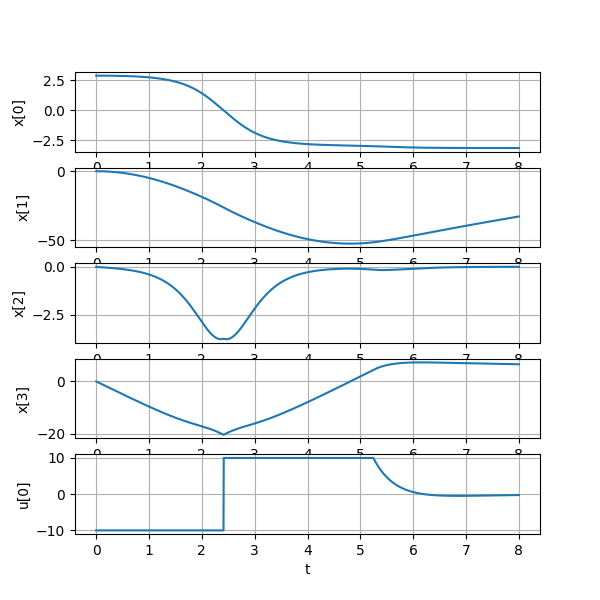

<IPython.core.display.Javascript object>


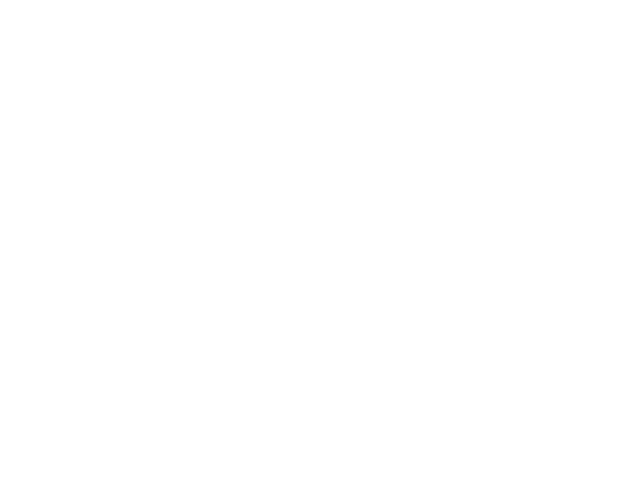

In [131]:
from inertial_wheel_pendulum import *
from IPython.display import HTML
from inertial_wheel_pendulum_visualizer import *
import matplotlib.pyplot as plt

def lqr_controller(x):
    # This should return a 1x1 u that is bounded
    # between -input_max and input_max.
    # Remember to wrap the angular values back to
    # [-pi, pi].
    u = np.zeros((1, 1))
    global xf, uf, K
    
    ''' 
    Code submission for 3.3: fill in the code below
    to use your computed LQR controller (i.e. gain matrix
    K) to stabilize the robot by setting u appropriately.
    '''
    xbar = x-xf
    xbar = (xbar + np.pi) % (2 * np.pi) - np.pi
    u = -np.dot(K,xbar) + uf
    u = max(-input_max,min(input_max,u))
    return u

# Run forward simulation from the specified initial condition
duration = 8.
x0 = [2.9, 0.0, 0.0, 0.0]
input_log, state_log = \
    RunSimulation(pendulum_plant,
              lqr_controller,
              x0=x0,
              duration=duration)

    
# Visualize state and input traces
fig = plt.figure().set_size_inches(6, 6)
for i in range(4):
    plt.subplot(5, 1, i+1)
    plt.plot(state_log.sample_times(), state_log.data()[i, :])
    plt.grid(True)
    plt.ylabel("x[%d]" % i)
plt.subplot(5, 1, 5)
plt.plot(input_log.sample_times(), input_log.data()[0, :])
plt.ylabel("u[0]")
plt.xlabel("t")
plt.grid(True)

# Visualize the simulation
viz = InertialWheelPendulumVisualizer(pendulum_plant)
ani = viz.animate(input_log, state_log, 30, repeat=True)
plt.close(viz.fig)
HTML(ani.to_html5_video())

## 3.4 LQR Region of Attraction, Prologue (2 points, 2/2 autograded)

As you probably found when playing with the LQR simulation in the previous question, there are plenty of states for which the LQR doesn't converge. **Find an x0 from which LQR does *not* converge, and an x0 from which is does, and write them below.**

In [132]:
'''
Code submission for 3.4
'''
def get_x0_does_not_converge():
    return [3, 0.0, 0.0, 0.0]
def get_x0_does_converge():
    return [2.9, 0.0, 0.0, 0.0]

## 3.5 LQR Region of Attraction, Episode 1 (5 points, 2/5 autograded)

What we would like to know is when the LQR controller will work, and when it won't. Let's see if we can analyze the region of attraction of this controller using the tools of Lyapunov stability analysis.

The closed-loop system dynamics of our system when using the LQR controller are

$$ \dot{x} = f(x, -K(x-x_f)) $$

A function that we know is a decent Lyapunov function near $x_f$ is the cost-to-go of the LQR solution: $V = \bar{x}^T S \bar{x}$.

Following section [10.3 of the textbook](http://underactuated.csail.mit.edu/underactuated.html?chapter=lyapunov), we just need to find a $\rho$ such that

$$ 
\dot{V}(x) \prec 0, \ \ \  \forall x : V(x) > 0
$$

to demonstrate the running LQR on our full (nonlinear!) system from state $x_0$ will converge as long as $V(x_0) \leq \rho$.

Let's start by calculating $\dot{V}(x)$ and $\dot{V}(x)$ for the full system. **Using the helper function *evaluate_f(x, u)* (it's a member of InertialWheelPendulum in *inertial_wheel_pendulum.py*) to fill out *calcV* and *calcVdot* to do this.**

Running this cell will populate the variables *V_samples*, *f_samples*, and *Vdot_samples* in the plane where $\theta_2 = 0$. Feel free to tweak those the sample grid (defined by n_bins, theta_widthm, etc) as you wish, but we'll be using these samples to estimate the region of attraction, so keep the resolution as high as you can while keeping the runtime reasonable. (We are, unfortunately, sampling in 3 dimensions...)

In [18]:
import matplotlib.pyplot as plt
import time

# Calculates the closed loop f(x) at xn
def calcF(xn):
    # Feel free to bring in whatever
    # global variables you need, e.g.:
    global pendulum_plant
    
    '''
    Code submission for 3.5: populate
    this function to calculate the closed-loop
    system dynamics f(x) at the input point.
    '''
    return np.zeros(4)

# Calculates V(xn)
def calcV(xn):
    # Feel free to bring in whatever
    # global variables you need

    '''
    Code submission for 3.5: populate
    this function to calculate V(x)
    at the input point.
    '''
    
    return 0.

# Calculates \dot{V}(xn).
def calcVdot(xn):
    # Feel free to bring in whatever
    # global variables you need
    
    '''
    Code submission for 3.5: populate
    this function to calculate Vdot(x)
    at the input point.
    '''

    return 0.

start_time = time.time()

# Sample f, V, and Vdot over
# a grid defined by these parameters.
# (Odd numbers are good because there'll be
# a bin at exactly the origin.
# These are slightly strange numbers as we've
# tried to default these to something as small
# as possible while still giving reasonable results.
# Feel free to increase if your computer and patience
# can handle it.)
n_bins = 41
n_bins_theta2d = 7
# For theta and thetad, we only need to span
# a small region around the fixed point
theta_width = 4
thetad_width = 4
# For \dot{theta_2}, though, the default
# parameters for our pendulum lead us to
# need to search larger absolute \dot{theta_2}
# values (because the inertial wheel is relatively
# light).
theta2d_width = 50

# Do the actual sampling....
x = np.linspace(xf[0]-theta_width, xf[0]+theta_width, n_bins)
y = np.linspace(xf[2]-thetad_width, xf[2]+thetad_width, n_bins)
z = np.linspace(xf[3]-theta2d_width, xf[3]+theta2d_width, n_bins_theta2d)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

def calc_over_array(f):
    return np.array([[[f([dx, 0., dy, dz]) for dz in z] for dx in x] for dy in y])

V_samples = calc_over_array(calcV)
f_samples = calc_over_array(calcF)
Vdot_samples = calc_over_array(calcVdot)

elapsed = time.time() - start_time
print "Computed %d x %d x %d sampling in %f seconds" % (n_bins, n_bins, n_bins_theta2d, elapsed)

Computed 41 x 41 x 7 sampling in 0.083296 seconds


<IPython.core.display.Javascript object>


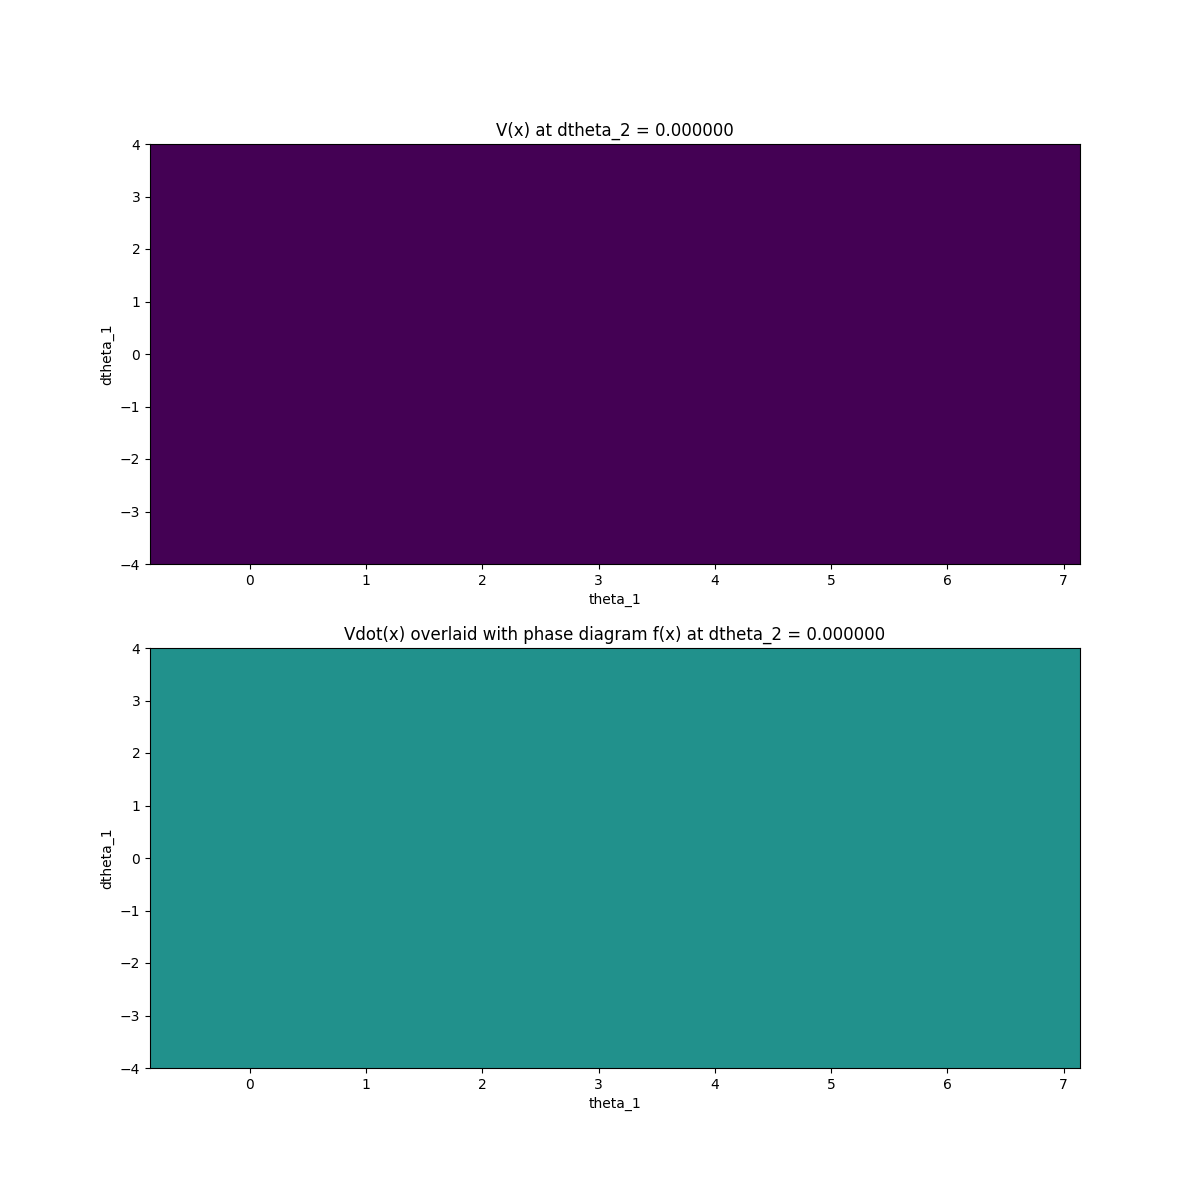

In [19]:
# This cell plots the samples using color-coded plots.
# Color coding:
#   V: blue = low-value, red = high-value
#   Vdot: blue = low value, yellow = around 0, red = high value
# The plot of Vdot is overlayed with a quiver plot of the samples
# of f.

# Select with slice of \dot{theta_2} we'll
# plot... this slice should be close to 0,
# as it's the middle bin.
theta2d_plotting_slice = n_bins_theta2d / 2

plt.figure().set_size_inches(12,12)

# Plot V
Xplot, Yplot = np.meshgrid(x, y)
plt.subplot(2, 1, 1)
plt.pcolormesh(Xplot, Yplot, V_samples[:, :, theta2d_plotting_slice])
plt.title("V(x) at dtheta_2 = %f" % z[theta2d_plotting_slice])
plt.xlabel("theta_1")
plt.ylabel("dtheta_1")

# Plot Vdot
# Use a sigmoid to try to squash the huge range of Vdot
# into something more visually appealing.
def sigmoid(x):
    return 1 / (1 + np.exp(-x/1000.))

plt.subplot(2, 1, 2)
Vdot_viz = sigmoid(Vdot_samples[:, :, theta2d_plotting_slice])
plt.pcolormesh(Xplot, Yplot, Vdot_viz, vmin=0, vmax=1.0)
plt.title("Vdot(x) overlaid with phase diagram f(x) at dtheta_2 = %f" % z[theta2d_plotting_slice])
plt.xlabel("theta_1")
plt.ylabel("dtheta_1")

# Don't plot a quiver arrow at *every* point, but instead
# every ds points
# (lower = more quiver arrows)
ds = 3
plt.quiver(Xplot[::ds, ::ds], 
           Yplot[::ds, ::ds], 
           f_samples[::ds, ::ds, 
           theta2d_plotting_slice, 0], f_samples[::ds, ::ds, theta2d_plotting_slice, 2]);

## 3.6 LQR Region of Attraction, Episode 2 (6 points, 3/6 autograded)

Now you should have access to (many samples from) your candidate $V$ and $\dot{V}$. One approach you could use from here is to estimate the region of attraction from these samples. Let's do that -- **use Theorem 10.5 from the textbook to estimate the largest region of attraction that you can for the LQR controller you derived above -- that is, find the biggest value of $\rho$ such that at every point $x_i$ where $V(x_i) \leq \rho$, $\dot{V}(x_i) \prec 0$.**

(Hint: it'll be easiest to do this by finding counterexample -- e.g., the point $x_i$ with the smallest $V(x_i)$ where $\dot{V}(x_i) \geq 0$.)

Region of attraction estimated at V(x) <=  0.0


<IPython.core.display.Javascript object>


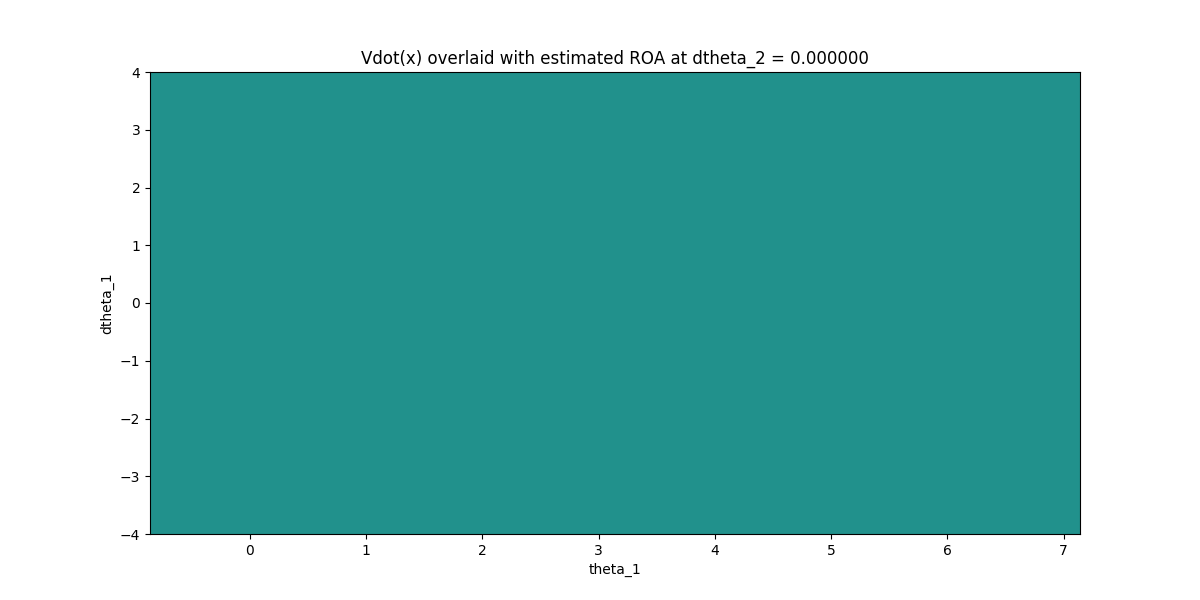

Area of your region of attraction:  0.0


In [20]:
def estimate_rho(V, Vdot):
    '''
    Code submission for 3.6
    Fill in this function to use the samples of V and Vdot
    (Each array has dimension [n_bins, n_bins, n_bins_theta2d])
    to compute a maximal rho indicating the region of attraction
    of the fixed point at the upright.
    '''
    
    return 0.

rho = estimate_rho(V_samples, Vdot_samples)
print "Region of attraction estimated at V(x) <= ", rho

# Plot Vdot again, but overlay the region of attraction -- which,
# for quadratic V, is an ellipse.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches(12,6)
plt.pcolormesh(Xplot, Yplot, Vdot_viz, vmin=0, vmax=1.0)

# The part of S we care about is the 2x2 submatrix from the 1st and 3rd rows
# and columns.
S_sub = np.reshape(S[[0, 2, 0, 2], [0, 0, 2, 2]], (2, 2))
# Extract its eigenvalues and eigenvectors, which tell us
# the axes of the ellipse
ellipseInfo = np.linalg.eig(S_sub)
# Eigenvalues are 1/r^2, Eigenvectors are axis directions
axis_1 = ellipseInfo[1][0, :]
if ellipseInfo[0][0] > 0 and ellipseInfo[0][1] > 0:
    r1 = math.sqrt(rho)/math.sqrt(ellipseInfo[0][0])
    axis_2 = ellipseInfo[1][1, :]
    r2 = math.sqrt(rho)/math.sqrt(ellipseInfo[0][1])
    angle = math.atan2(-axis_1[1], axis_1[0])
    from matplotlib.patches import Ellipse
    ax.add_patch(Ellipse((xf[0], xf[2]), 
                         2*r1, 2*r2, 
                         angle=angle*180./math.pi, 
                         linewidth=2, fill=False, zorder=2));
    
    # Report an interesting number that is easy to compute
    # from the ellipse info
    print "Area of your region of attraction: ", math.pi * r1 * r2
else:
    print "S_sub had nonpositive eigenvalues. That shouldn't happen."
    
plt.title("Vdot(x) overlaid with estimated ROA at dtheta_2 = %f" % z[theta2d_plotting_slice])
plt.xlabel("theta_1")
plt.ylabel("dtheta_1");

## 3.7 LQR Region of Attraction, Intermission (3 points)

1) Is this sufficient proof that LQR *would* work starting from $x_0$ *inside* region of attraction (ignoring sampling errors)? 

2) What about the opposite -- is this sufficient proof that LQR *would not* work starting from $x_0$ *outside* of this region of attraction?

3) If you answer to (2) is No, speculate what strategies we could use to find larger regions of attraction. (For example, could changing V increase the largest ROA we could guarantee? How could we formulate search over V?)

**Short answer explanation for 3.7**

1) YOUR ANSWER HERE

2) YOUR ANSWER HERE

3) YOUR ANSWER HERE

## 3.8 Combined Swing-up and Stabilization (8 points, 4/8 autograded)

Finally, we're ready for the main event! **Write a controller that will accomplish the task of swinging up the inertial pendulum to its upright fixed point from any initial condition. Your controller should use a custom swingup controller to get close to the unstable fixed point, and then switch to LQR to stay there. Use your estimated region of attraction to decide when it's safe to switch to LQR. A framework for setting up this hybrid controller is provided below for your convenience.**

To accomplish swing-up, apply energy shaping to $\theta$ via non-collocated feedback linearization. (Energy shaping for $\theta$ should follow from the simple pendulum, so you just need figure out how to use your non-collocated input $\tau$ to directly apply torque on $\theta$.)

While we'll look at your code, we'll also rely on the autograder to test your system from a variety of initial conditions. (You can try the autograder with the cell at the bottom of the notebook.) Besides the random initial conditions we'll test, we'll also check:
- $x = \left[ 0, 0, 0, 0 \right] $
- $x = \left[ \pi, 0, 0, 0 \right] $
- $x = \left[ 3\pi, 0, 0, 0 \right] $
- $x = \left[ 0, -100, 0, 0 \right] $
- $x = \left[ 0, 0, 0, 20 \right] $

Make sure you can handle these corner cases!

<IPython.core.display.Javascript object>


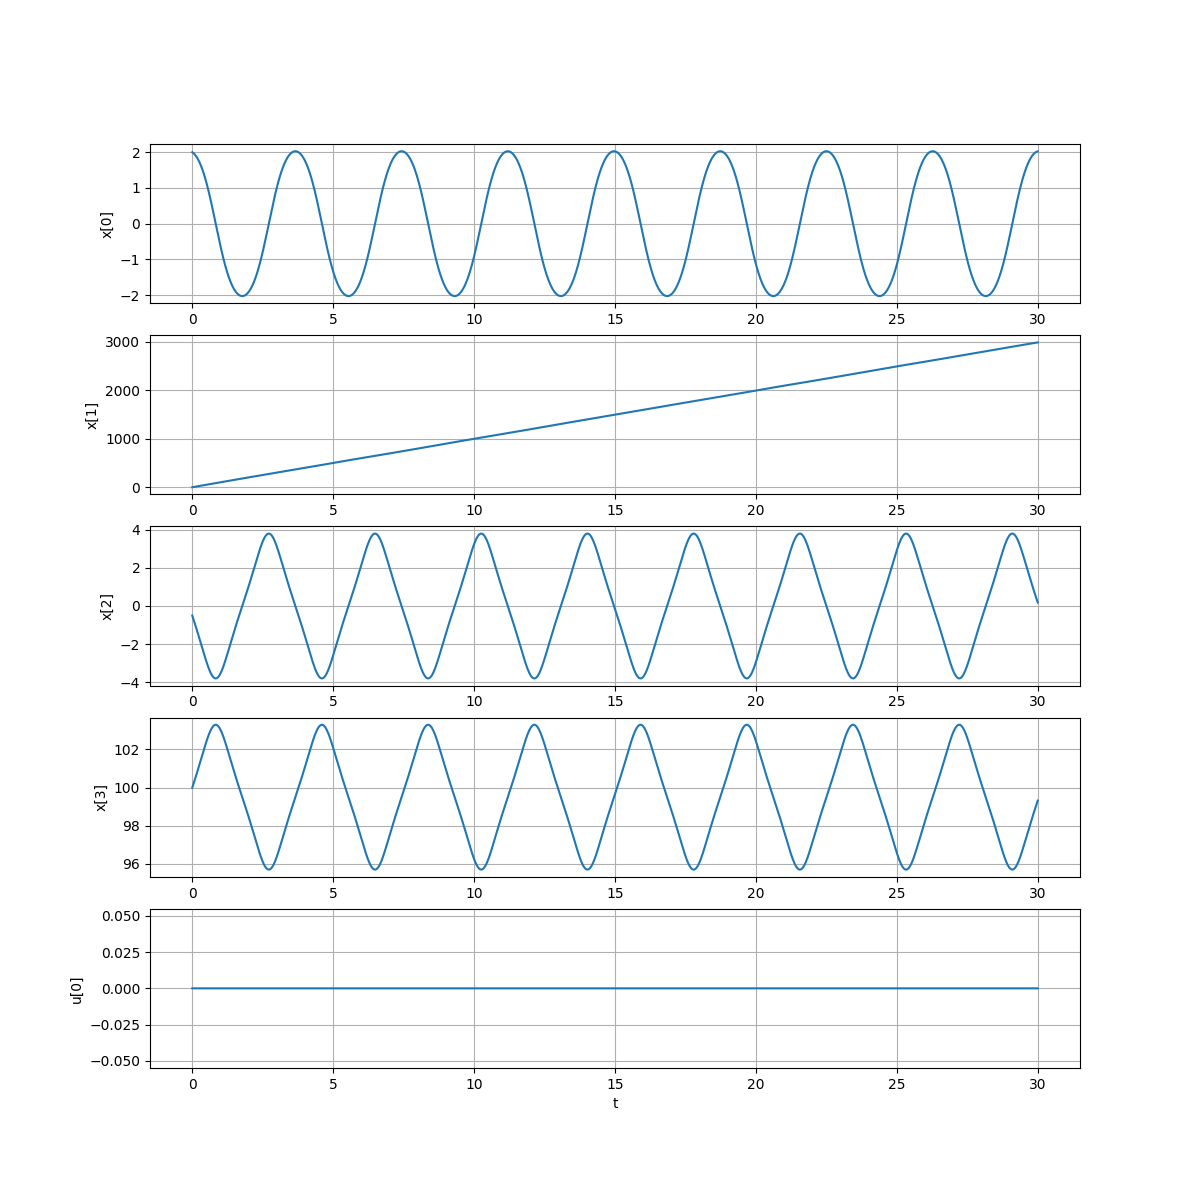

In [21]:
# The swingup controller should accept a state x,
# and return a control input u (a 1x1 numpy array)
# that respects the plant's input limits.
def swingup_controller(x):
    # Here's some useful things...
    q = x[0:2]
    qd = x[2:4]
    (M, C, tauG, B) = pendulum_plant.GetManipulatorDynamics(q, qd)
    
    ''' 
    Code response for problem 3.8:
    Fill in this swingup controller to control the pendulum
    energy to the homonclinic orbit.
    (You'll probably want to ensure that your controller
    controls the velocity of the inertial wheel, too, using whatever
    means you think are reasonable.)
    '''
    u = np.array([0.])
    return u

def combined_controller(x):
    ''' 
    Code response for problem 3.8:
    Fill in this combined controller to dispatch to either the
    swingup or lqr controller by checking the state against your
    calculated region of attraction.
    '''
    u = np.array([0.])
    return u

# Simulate!
x0 = [2.0, 0.0, -0.5, 100.]
duration = 30
input_log, state_log = RunSimulation(pendulum_plant,
                        combined_controller,
                        x0 = x0,
                        duration = duration)

# Plot traces of the results
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(12,12)
for i in range(4):
    plt.subplot(5, 1, i+1)
    plt.plot(state_log.sample_times(), state_log.data()[i, :])
    plt.grid(True)
    plt.ylabel("x[%d]" % i)
plt.subplot(5, 1, 5)
plt.plot(input_log.sample_times(), input_log.data()[0, :])
plt.ylabel("u[0]")
plt.xlabel("t")
plt.grid(True)

<IPython.core.display.Javascript object>


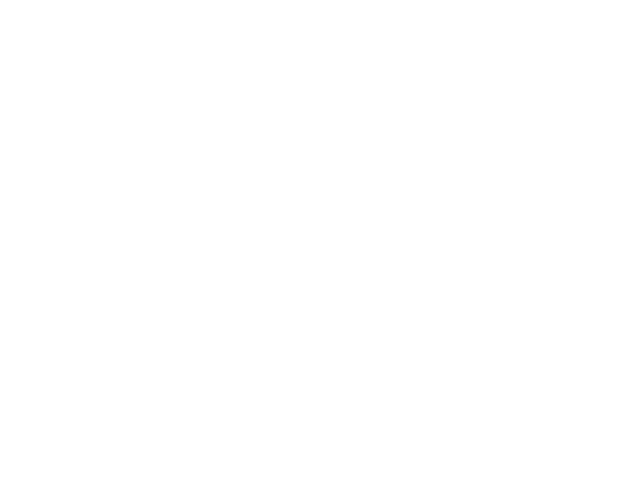

In [22]:
from IPython.display import HTML
from inertial_wheel_pendulum_visualizer import *

viz = InertialWheelPendulumVisualizer(pendulum_plant)
ani = viz.animate(input_log, state_log, 30, repeat=True)
plt.close(viz.fig)
HTML(ani.to_html5_video())

# 4. Sum-of-squares verification for wheel pendulumn

In the following, we will first walk you through an example that uses sum-of-squares optimization to verify the global stability of a dampled pendulumn. Then we will ask you to verify the stability of the derived LQR controller on the wheel pendulumn.

## 4.1 Sos verification for the dampled pendulumn (4 points)

The mechanical energy provides a simple intuition for us to discuss the stability of the dampled pendulumn. However, it might not work for more complex systems. To provide a more principled solution, we could find a Lyapunov function for non-linear systems using sum-of-square optimization. The sum-of-square optimization can be converted into semi-definite programming (SDP), which is a special form of convex optimization and can be solved to optimality. Before working on this problem, you should take a look at the `mathematical_program_and_sos_examples.ipynb` to understand the API of `MathematicalProgram`.

Following is the code for finding a Lyapunov function to verify the stability of the damped pendulumn using sum-of-squares optimization. It basically solves an SoS with respect to the following three constraints (let's assume $x_0$ is the fixed point at the bottom):

- $V$ is strictly positive when the state is away from $x_0$.
- $\dot{V}$ is strictly negative away from $x_0$ (except for the fixed point at the top).
- $V$ should be $0$ at $x_0$.


For more details, please see example 10.3 in the [textbook](http://underactuated.csail.mit.edu/underactuated.html?chapter=lyapunov).

Play with the code and answer the following questions:

1) Explain the functionality of the term ```eps*(x-x0).dot(x-x0)``` used in ```contraint1```.

2) We multiply ```s**2``` with ```eps*(x-x0).dot(x-x0)``` in ```constraint2```. What will happen if we remove the term ```s**2``` and why?


**Answer for 4.1**

1) YOUR ANSWER HERE

2) YOUR ANSWER HERE

In [23]:
import numpy as np
from pydrake.all import MathematicalProgram, Solve, Variables
from pydrake.symbolic import Polynomial
from pydrake.examples.pendulum import PendulumParams

# Define mathematical program
prog = MathematicalProgram()

# Using the default pendulum parameters
# mass = 1.0 kg
# length = 0.5 m
# dampling = 0.1 kg m^2/s
# gravity = 9.81 m/s^2
p = PendulumParams()

# Define sin(theta)
s = prog.NewIndeterminates(1, 's')[0]
# Define cos(theta)
c = prog.NewIndeterminates(1, 'c')[0]
# Define thetadot
thetadot = prog.NewIndeterminates(1, 'thetadot')[0]
# Construct state x
x = np.array([s, c, thetadot])
# Define the second-order derivative of the system
f = [ c*thetadot, -s*thetadot, (-p.damping()*thetadot - p.mass()*p.gravity()*p.length()*s)/(p.mass()*p.length()*p.length())]

# Define the equilibrium point at the bottom
x0 = np.array([0, 1, 0])
eps = 1e-4

deg_V = 2
# Lyapunov function
V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()
# V is strictly positive away from x0
constraint1 = V - eps*(x-x0).dot(x-x0)
prog.AddSosConstraint(constraint1)

# Derivative of the Lyapunov function
Vdot = V.Jacobian(x).dot(f)

deg_L = 2;
L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()
# Vdot is strictly negative away from x0
constraint2 =  -Vdot - L*(s**2+c**2-1) - eps*(x-x0).dot(x-x0)*s**2 
prog.AddSosConstraint(constraint2)

# Add V(x0) = 0 constraint
constraint3 = V.Substitute({s: 0, c: 1, thetadot: 0}) == 0
prog.AddLinearConstraint(constraint3)

# Solve it
result = Solve(prog)
print 'Is the solving success? ', result.is_success()
print('V =')
Vsol = Polynomial(result.GetSolution(V));
print(Vsol.RemoveTermsWithSmallCoefficients(1e-6))

print('Mechanical Energy = ')
print(.5*p.mass()*p.length()**2*thetadot**2 - p.mass()*p.gravity()*p.length()*c)

Is the solving success?  True
V =
0.00079618768444413783*s(0) * thetadot(0) + 0.19997914637751854*c(0)^2 + -0.39995040425479739*c(0) + 0.19997132871653886*1 + 0.01005229074752083*thetadot(0)^2 + 0.19228672710509243*s(0)^2
Mechanical Energy = 
( - 4.9050000000000002 * c(0) + 0.125 * pow(thetadot(0), 2))


We then map the derived Lyapunov function back to the original coordinate space and visualize as a countour plot, which looks a lot like mechanical energy.

In [ ]:
%matplotlib notebook  
import matplotlib.pyplot as plt

# Plot the results
nq = 151
nqd = 151
q = np.linspace(-2*np.pi, 2*np.pi, nq)
qd = np.linspace(-2*p.mass()*p.gravity()*p.length(), 2*p.mass()*p.gravity()*p.length(), nqd)
Q, QD = np.meshgrid(q, qd)
Z = Q.copy()
env = {s: 0., c: 1., thetadot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = np.sin(Q[i, j])
        env[c] = np.cos(Q[i, j])
        env[thetadot] = QD[i, j]
        Z[i, j] = Vsol.Evaluate(env)
    
#plt.rc('text', usetex=True)
fig, ax = plt.subplots()
ax.contour(Q,QD,Z)
ax.set_xlabel('theta')
ax.set_ylabel('thetadot')
ax.set_title('V')

plt.savefig("pend_global_sos.svg")

## 4.2 Bonus Question: Sum-of-square verification of wheel pendulum (5 points)

In this problem, you will apply the sum-of-square optimization to verifiy the region of attraction obtained in Problem 3.6, and the verified close-loop system contains the LQR controller you implemented. The original system has torque limits. In this problem, we remove the torque limit for the simplicity of your implementation.

You have already seen the re-parameterization of $\theta$ into sin$(\theta)$ and cos$(\theta)$ in the above pendulumn example. However, the LQR controller for the system requires the angle $\theta$ as part of the state. Thus, we use higher-order Taylor expansion of sin$(\theta)$ around the fixed point as an approximation of the true dynamics.

In [24]:
def sin_taylor_around_pi(t, order):
    '''
    Approximates the sine function around pi using Taylor series.
    '''
    if order < 1:
        raise ValueError('The order of the Taylor expansion must be at least 1.') 
    a = (t - np.pi)
    s = - a
    for i in range(1, (order+1)/2):
        a *= -1 * (t-np.pi)**2 / ((2*i) * (2*i+1))
        s -= a
    return s

<IPython.core.display.Javascript object>


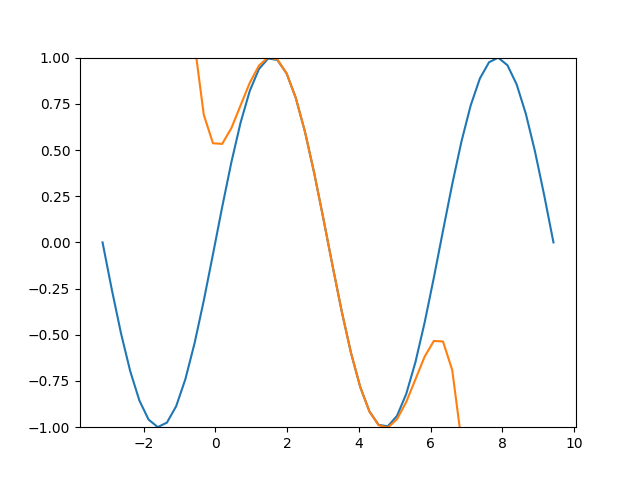

(-1.0000000000, 1.0000000000)

In [25]:
# Plot the talyor approximation
import matplotlib.pyplot as plt
t = np.linspace(-np.pi, 3*np.pi)
fig = plt.figure()
plt.plot(t, np.sin(t))
plt.plot(t, sin_taylor_around_pi(t, 5))
plt.ylim(-1.,1.)

The cell below initializes the optimization problem and prepares several dynamic terms. Note that the angle of the pendulum in this problem is relative to the top position (the fixed point), which will make solver more stable to numerical errors. Before working on this problem, you should take a look at the `mathematical_program_and_sos_examples.ipynb` to understand the API of `MathematicalProgram`.

You should skim through this cell but you don't need to modify any code in it.

In [26]:
from pydrake.all import MathematicalProgram, Variables, SolutionResult, Solve

# intializion of the optimization problem
prog = MathematicalProgram()

# Reduced state of the system as a set of indeterminates
# for the SOS verification
# x[0] = angle of the pendulum relative to np.pi (the fixed point)
# x[1] = velocity of the pendulum
# x[2] = velocity of the wheel
nx = 3
x = prog.NewIndeterminates(nx, 'x')
x_eq = np.array([np.pi, 0., 0.])

# The dynamic of the pendulum
M = np.array([
    [m1*l1**2 + m2*l2**2 + pendulum_plant.I1 + pendulum_plant.I2, pendulum_plant.I2],
    [pendulum_plant.I2, pendulum_plant.I2]
])
C = np.array([
    [0, 0],
    [0, 0]
])
B = np.array([
    [0.],
    [1.]
])

# The torque caused by gravity. Note that the taylor approximation is used here
order_sine = 5
tauG = np.array([
    -(m1*l1 + m2*l2)*g*sin_taylor_around_pi(x[0]+x_eq[0], order_sine),
    0.
])

# lqr solution
print(K.shape)
print(S.shape)
K_reduced_sos = np.delete(K, (1), axis=1)
print(K_reduced_sos)
S_reduced_sos = np.delete(np.delete(S, (1), axis=0), (1), axis=1)

# closed-loop dynamics in the form x_dot = f(x)
xdot = np.concatenate([
    [x[1]],
    np.linalg.inv(M).dot(-C.dot(x[1:3]) + tauG - B.dot(K_reduced_sos).dot(x)),
])

(1, 4)
(4, 4)
[[ 0.  0.  0.]]


In the cell below, you need to add a contraint to the optimization problem to ensure the time derivate of the Lyapunov function is negative. You might take a look at example 10.7 of the [textbook](http://underactuated.csail.mit.edu/underactuated.html?chapter=lyapunov). This question will be graded manually.

In [27]:
# LQR cost-to-go as Lyapunov function
V = .5*x.dot(S_reduced_sos).dot(x)

# time derivative of the Lyapunov function
Vdot = x.dot(S_reduced_sos).dot(xdot)

# for S-procedure
lambda_degree = 4
(lambda_sos, constraint) = prog.NewSosPolynomial(Variables(x), lambda_degree)

# Replace with the result you obtained in Problem 3.6
V_roa_from_sampling = 100.0

# Add a constraint to ensure the time derivative of 
# the Lyapunov function should be negative
# If you leave the following contraint empty, the optimization has trivial solution, which is not meaningful.
### YOUR CODE HERE

### END OF YOUR CODE

# Solve it
result = Solve(prog)
if result.is_success():
    print 'The stability of your close-loop system is verified!'
else:
    print 'The verification is not successful, you might need some modification.'

The stability of your close-loop system is verified!


## Test your own implementations

Running the cell below will run your implemented functions against unit tests.

Don't change the cell below, or the test_set_3.py file. We will grade your implementations against the original files.

Make sure to SAVE your notebook before running tests. (File --> Save and Checkpoint, or use the hotkey which should be ctrl+s on linux, cmd+s on osx, etc)

**Warning: these take a little while to run, so run them sparingly!** (They test your code by testing the inertial pendulum from lots of initial conditions...) You can speed it up a little by decreasing the time it takes to run every part of the notebook (e.g. sample V less frequently in 3.5, simulate plants for a shorter duration.)

In [11]:
import os
# Run the test in a subprocess, to make sure it doesn't open any plots...
os.popen("python test_set_3.py ./ test_results.json")

# Print the results json for review
import test_set_3
print test_set_3.pretty_format_json_results("test_results.json")

TOTAL SCORE (automated tests only): 0.00
  * Unknown exception while setting up: Traceback (most recent call last):
  * File "test_set_3.py", line 458, in run_tests     lambda:
  * imp.load_source('set_3_for_testing',
  * '/tmp/set_3_for_testing.py'))() IOError: [Errno 32] Broken pipe




## Feedback Survey

We'd really appreciate your feedback on this set, and on the class so far! Anonymous survey [available here](https://goo.gl/forms/gSqeSnMdY8WHeCiC2).

./


<IPython.core.display.Javascript object>


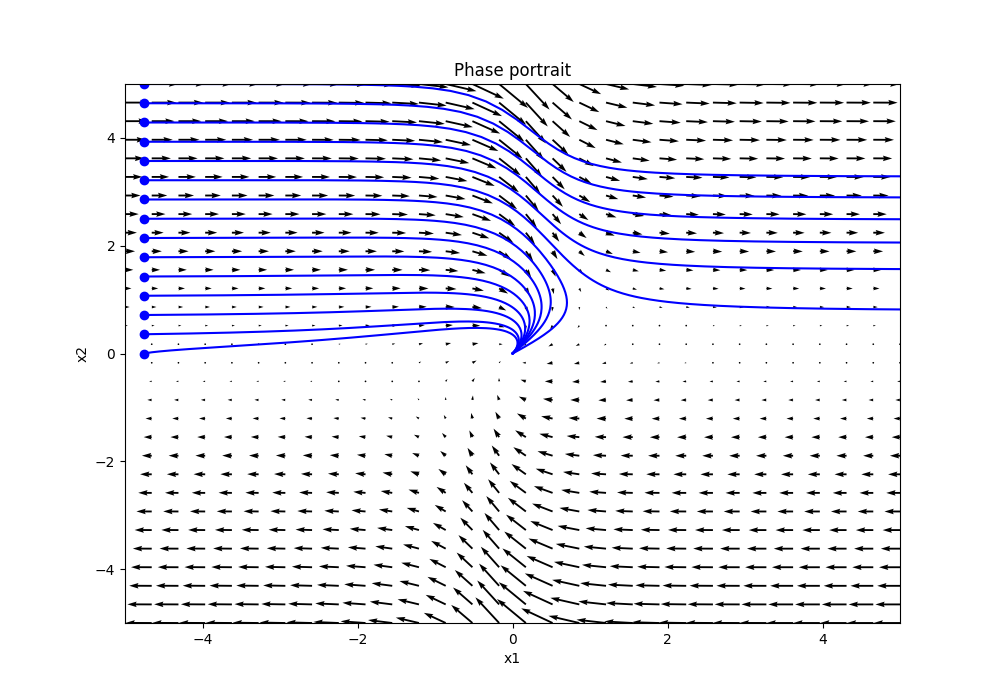

Q =  [[ 2 -1  1]
 [-1  5  0]
 [ 1  0  1]]
True
[-1.  1.]
('A: ', array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 5.,  0.,  0.,  0.],
       [-5.,  0.,  0.,  0.]]))
('B: ', array([[ 0. ],
       [ 0. ],
       [-0.1],
       [ 1.1]]))
A:  [[ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 5.  0.  0.  0.]
 [-5.  0.  0.  0.]]
B:  [[ 0. ]
 [ 0. ]
 [-0.1]
 [ 1.1]]
Is controllable?  [[ 0.  -0.1  0.  -0.5]
 [ 0.   1.1  0.   0.5]
 [-0.1  0.  -0.5  0. ]
 [ 1.1  0.   0.5  0. ]]
True
LQR K:  [[ nan  nan  nan  nan]]
Oh no!
K:  [-145.425    0.     -66.05    -1.   ]
S:  [[ 4753.172     0.     2180.804    66.05 ]
 [    0.        0.        0.        0.   ]
 [ 2180.804     0.     1001.43     30.994]
 [   66.05      0.       30.994     1.909]]


<IPython.core.display.Javascript object>


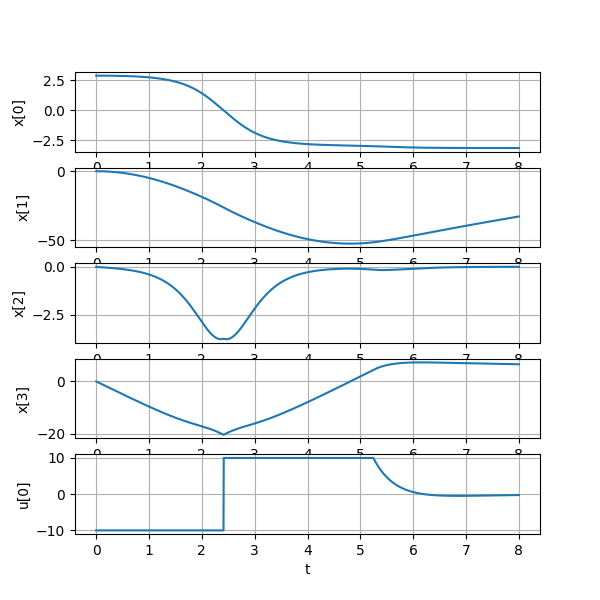

<IPython.core.display.Javascript object>


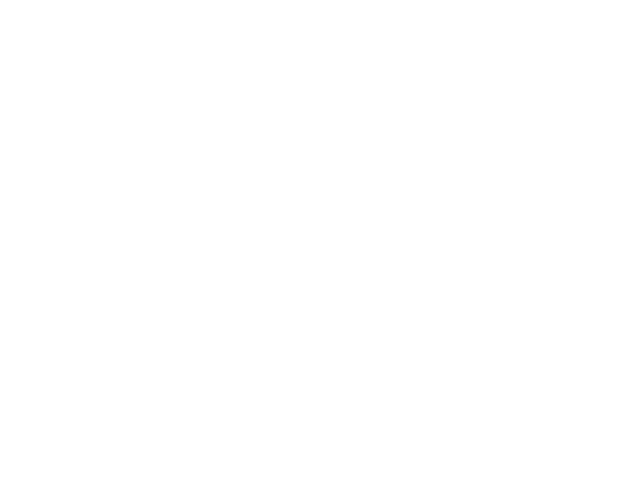

Computed 41 x 41 x 7 sampling in 0.053995 seconds


<IPython.core.display.Javascript object>


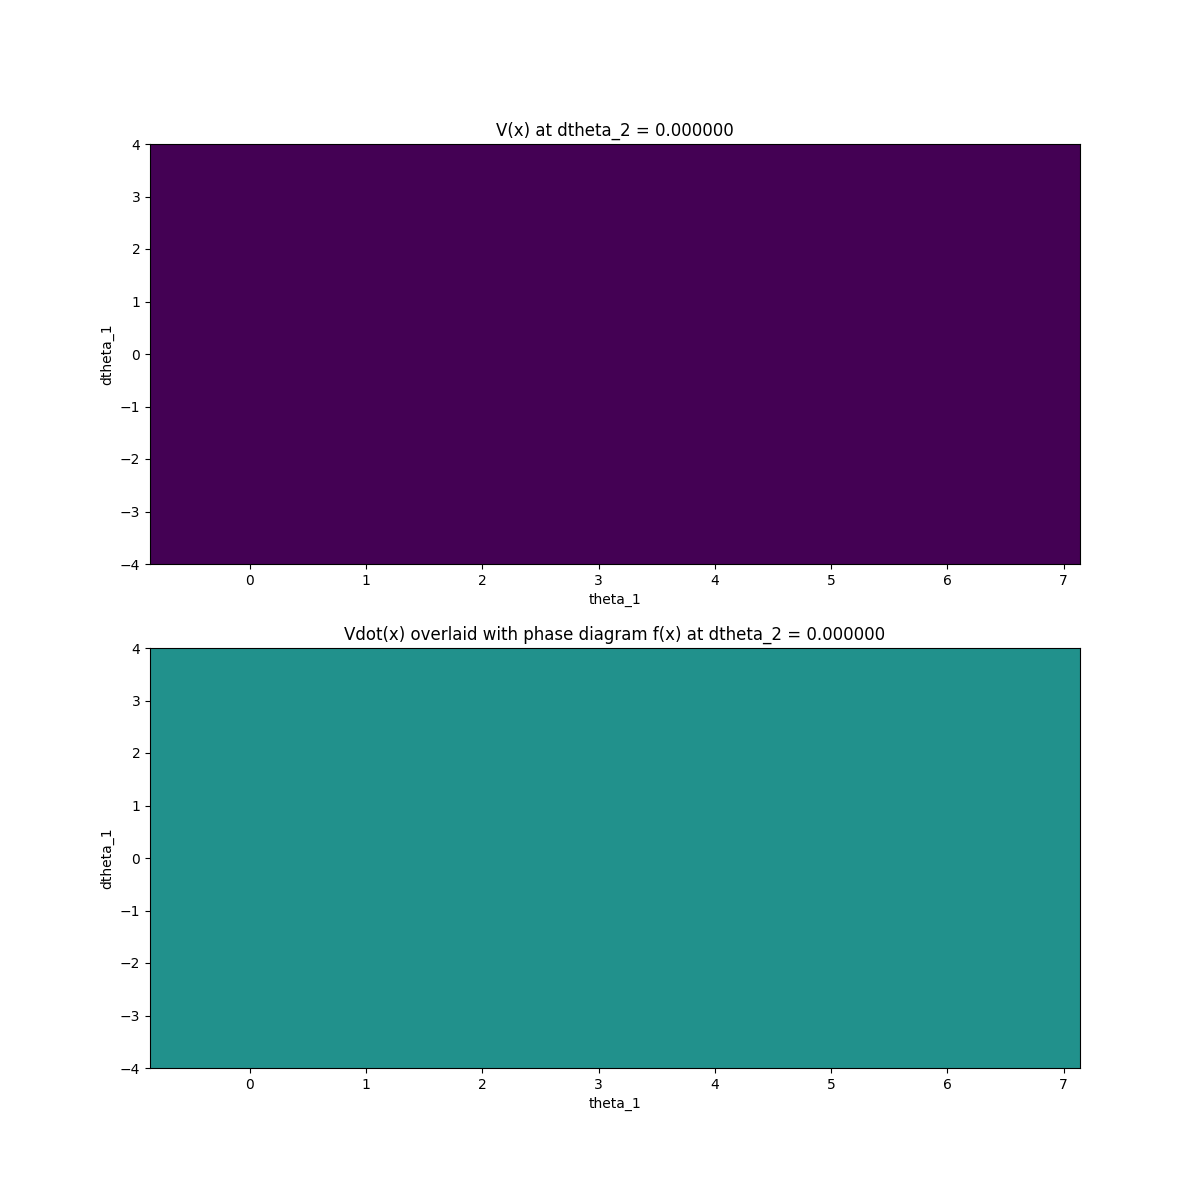

Region of attraction estimated at V(x) <=  0.0


<IPython.core.display.Javascript object>


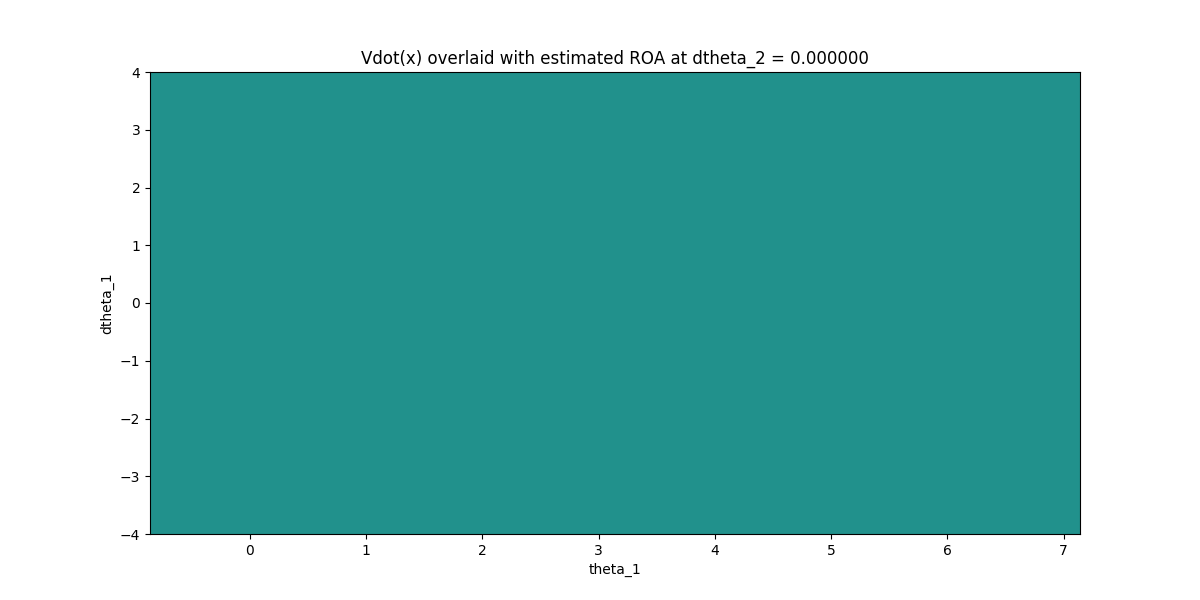

Area of your region of attraction:  0.0


<IPython.core.display.Javascript object>


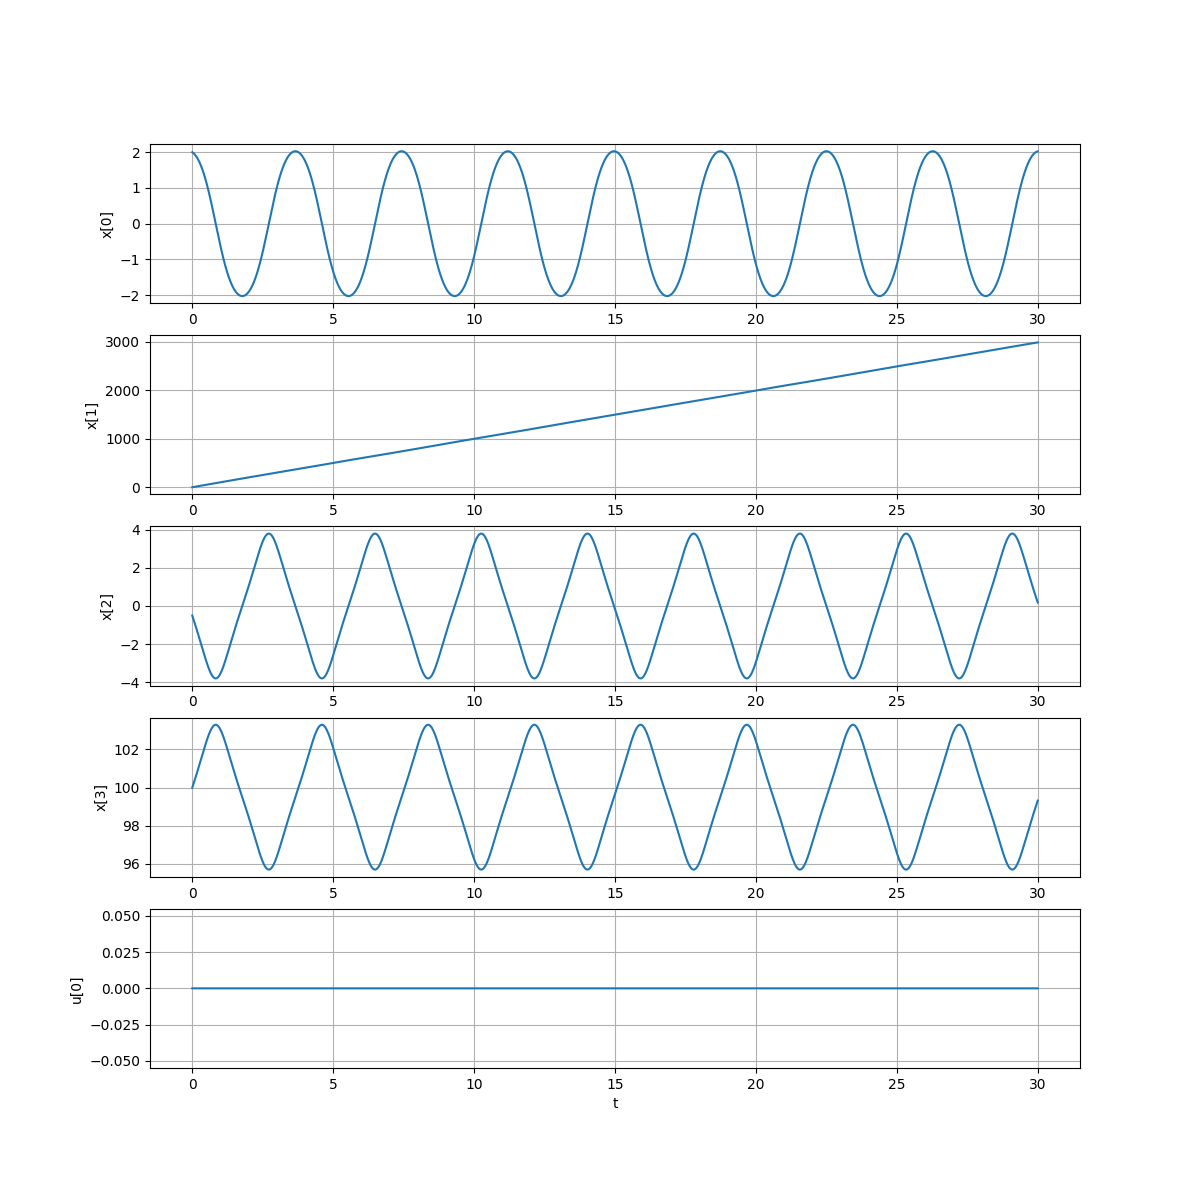

<IPython.core.display.Javascript object>


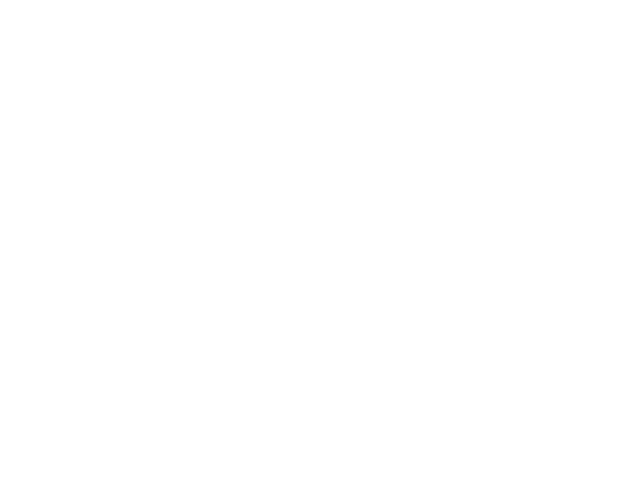

Is the solving success?  True
V =
0.00079618768444413783*s(0) * thetadot(0) + -0.39995040425479739*c(0) + 0.19997132871653886*1 + 0.19228672710509243*s(0)^2 + 0.19997914637751854*c(0)^2 + 0.01005229074752083*thetadot(0)^2
Mechanical Energy = 
( - 4.9050000000000002 * c(0) + 0.125 * pow(thetadot(0), 2))


<IPython.core.display.Javascript object>


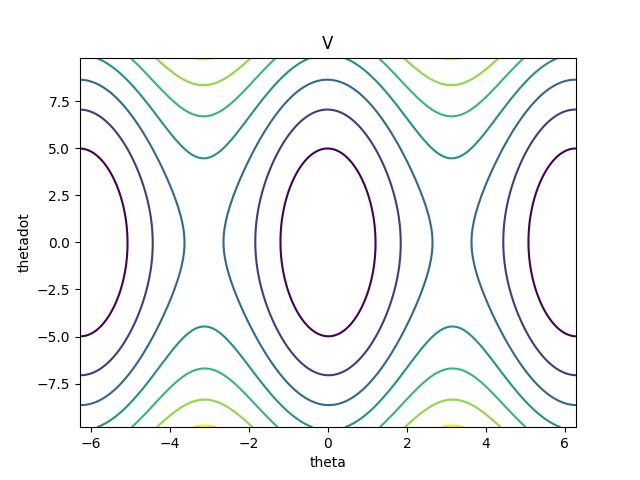

<IPython.core.display.Javascript object>


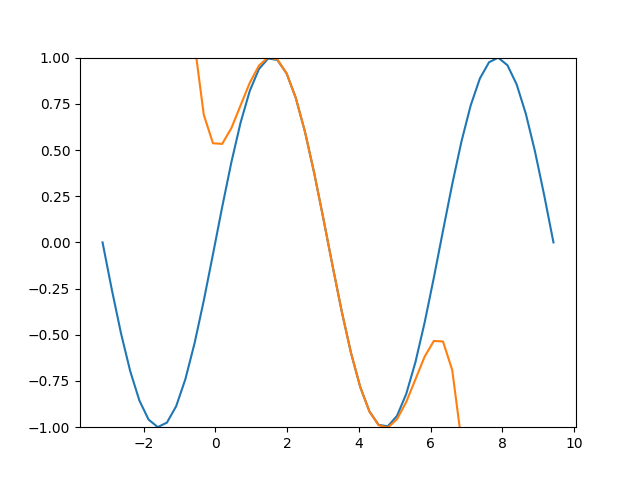

(4,)
(4, 4)


In [135]:
test_set_3.run_tests()